# Finance clustering 

## Yahoo Finance

https://finance.yahoo.com/

In [2]:
!pip install yfinance

In [4]:
!pip install selenium 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 2.3 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.9/384.9 kB 1.3 MB/s eta 0:00:0000:0100:01
  Using cached h11-0.14.0-py3-none-any.whl (58 kB)


In [5]:
import sys
sys.path.append(
    "../"
)

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import time
from tqdm.autonotebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from selenium import webdriver
import yfinance as yf

In [6]:
def get_info(ticker_obj):
    info_keys = ['shortName', 'sector', 'industry', 'country', 'market']
    info_values = []
    for key in info_keys:
        info_values.append(ticker_obj.info.get(key, None))
    return dict(zip(info_keys, info_values))

In [7]:
msft = yf.Ticker("MSFT")
msft.history()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-01-17 00:00:00-05:00,237.970001,240.910004,237.089996,240.350006,29831300,0,0
2023-01-18 00:00:00-05:00,241.570007,242.380005,235.520004,235.809998,30028700,0,0
2023-01-19 00:00:00-05:00,233.779999,235.520004,230.679993,231.929993,28623000,0,0
2023-01-20 00:00:00-05:00,234.860001,240.740005,234.509995,240.220001,35323400,0,0
2023-01-23 00:00:00-05:00,241.100006,245.169998,239.649994,242.580002,31934000,0,0
2023-01-24 00:00:00-05:00,242.500000,243.949997,240.440002,242.039993,40234400,0,0
2023-01-25 00:00:00-05:00,234.479996,243.300003,230.899994,240.610001,66526600,0,0
2023-01-26 00:00:00-05:00,243.649994,248.309998,242.000000,248.000000,33454500,0,0
2023-01-27 00:00:00-05:00,248.990005,249.830002,246.830002,248.160004,26480800,0,0


In [8]:
get_info(msft)

{'shortName': None,
 'sector': None,
 'industry': None,
 'country': None,
 'market': None}

## In case you need all tickers

In [9]:
all_tickers = pd.read_csv(
    'https://raw.githubusercontent.com/shilewenuw/get_all_tickers/master/get_all_tickers/tickers.csv', 
    header=None,
    error_bad_lines=False
)

all_tickers = all_tickers.values.reshape(-1)
print(len(all_tickers))
print(all_tickers[:4]) # ['DDD' 'MMM' 'WBAI' 'WUBA']

2762
['DDD' 'MMM' 'WBAI' 'WUBA']


## Loading interesting tickers

In [10]:
from selenium.webdriver.common.by import By

def load_with_selenium(url, chromedriver_path='C:/Windows/chromedriver.exe'): # https://chromedriver.chromium.org/downloads
    driver = webdriver.Chrome(chromedriver_path)
    driver.get(url)
    driver.implicitly_wait(2)
    df = pd.read_html(driver.find_element(By.TAG_NAME, "table").get_attribute('outerHTML'))[0]
    driver.close()
    return df

In [11]:
%%time
n_group = 25

trending = load_with_selenium(f"https://finance.yahoo.com/trending-tickers?count={n_group}")
most_active = load_with_selenium(f"https://finance.yahoo.com/most-active?count={n_group}")
gainers = load_with_selenium(f"https://finance.yahoo.com/gainers?count={n_group}")
losers = load_with_selenium(f"https://finance.yahoo.com/losers?count={n_group}")

WebDriverException: Message: unknown error: cannot find Chrome binary
Stacktrace:
0   chromedriver                        0x0000000103232138 chromedriver + 4923704
1   chromedriver                        0x00000001031aa9d3 chromedriver + 4368851
2   chromedriver                        0x0000000102df3787 chromedriver + 472967
3   chromedriver                        0x0000000102e1e3ca chromedriver + 648138
4   chromedriver                        0x0000000102e1c041 chromedriver + 639041
5   chromedriver                        0x0000000102e6a8a5 chromedriver + 960677
6   chromedriver                        0x0000000102e60d23 chromedriver + 920867
7   chromedriver                        0x0000000102e27a4b chromedriver + 686667
8   chromedriver                        0x0000000102e29044 chromedriver + 692292
9   chromedriver                        0x00000001031fd8fe chromedriver + 4708606
10  chromedriver                        0x0000000103202e22 chromedriver + 4730402
11  chromedriver                        0x000000010320b6bf chromedriver + 4765375
12  chromedriver                        0x0000000103203e80 chromedriver + 4734592
13  chromedriver                        0x00000001031d4975 chromedriver + 4540789
14  chromedriver                        0x0000000103225e78 chromedriver + 4873848
15  chromedriver                        0x0000000103225ff5 chromedriver + 4874229
16  chromedriver                        0x000000010323a6de chromedriver + 4957918
17  libsystem_pthread.dylib             0x00007ff8149314e1 _pthread_start + 125
18  libsystem_pthread.dylib             0x00007ff81492cf6b thread_start + 15


In [12]:
trending.head()

NameError: name 'trending' is not defined

In [ ]:
most_active.head()

In [ ]:
gainers.head()

In [ ]:
losers.head()

In [91]:
# Исключим пересечения. Возьмем только уникальные тикеты
interesting_tickers = set()

for df in [trending, most_active, gainers, losers]:
    interesting_tickers = interesting_tickers.union(set(df['Symbol']))
    
interesting_tickers = list(interesting_tickers)
print(interesting_tickers[:4])
print(len(interesting_tickers))

['GOOGL', 'GOEV', 'NPSCY', 'DNPLY']
87


In [92]:
# True about 15-20 min 
# False - use prepared data from full_ticker_df_month.csv

load = False

if load:
    full_ticker_data = []
    for ticker in tqdm(interesting_tickers):
        try:
            ticker_obj = yf.Ticker(ticker)
            close_price = ticker_obj.history(period='1mo', interval='1d')['Close'].to_dict()
            info = get_info(ticker_obj)
            info.update(close_price)
            full_ticker_data.append(info)
        except Exception as e:
            print(e)
            continue
        
    full_ticker_df = pd.DataFrame(full_ticker_data)
    full_ticker_df.to_csv("full_ticker_df_month.csv")

else: 
    full_ticker_df = pd.read_csv("full_ticker_df_month.csv", index_col=0)
    datetime_columns = pd.to_datetime(full_ticker_df.columns[5:])
    full_ticker_df.columns = list(full_ticker_df.columns[:5]) + list(datetime_columns)

In [93]:
full_ticker_df.head()

,shortName,sector,industry,country,market,2022-07-18 00:00:00,2022-07-19 00:00:00,2022-07-20 00:00:00,2022-07-21 00:00:00,2022-07-22 00:00:00,...,2022-08-05 00:00:00,2022-08-08 00:00:00,2022-08-09 00:00:00,2022-08-10 00:00:00,2022-08-11 00:00:00,2022-08-12 00:00:00,2022-08-15 00:00:00,2022-08-16 00:00:00,2022-08-17 00:00:00,2022-08-18 00:00:00
0,Farfetch Limited,Consumer Cyclical,Internet Retail,United Kingdom,us_market,6.73,7.760000,8.350000,8.820000,8.360000,...,8.94,9.720000,8.880000,9.710000,9.900000,10.160000,9.930000,9.99,8.830000,NaN
1,Snap Inc.,Communication Services,Internet Content & Information,United States,us_market,13.92,14.150000,15.510000,16.350000,9.960000,...,10.18,10.410000,10.160000,10.570000,11.110000,11.620000,12.240000,12.61,12.090000,NaN
2,"Arvinas, Inc.",Healthcare,Biotechnology,United States,us_market,47.50,51.919998,54.560001,54.799999,50.320000,...,55.43,55.830002,55.799999,57.990002,54.540001,54.459999,54.119999,52.48,46.700001,NaN
3,COLOPLAST SPON ADS EACH REPR 0.,Healthcare,Medical Instruments & Supplies,Denmark,us_market,11.19,11.425000,11.205000,11.810000,11.850000,...,11.34,11.410000,11.380000,11.730000,11.820000,11.600000,11.585000,11.34,12.170000,NaN
4,Carvana Co.,Consumer Cyclical,Internet Retail,United States,us_market,22.25,22.850000,27.379999,28.209999,25.379999,...,46.98,46.459999,41.430000,47.310001,50.130001,52.099998,51.000000,54.59,49.619999,NaN


In [94]:
full_ticker_df.shape

(96, 29)

In [95]:
full_ticker_df.isnull().sum(axis=1)

0     1
1     1
2     1
3     1
4     1
     ..
91    1
92    1
93    1
94    1
95    1
Length: 96, dtype: int64

In [96]:
full_ticker_df = full_ticker_df.iloc[:, :-1] # Выбросим пустой столбец

In [97]:
prices = full_ticker_df.iloc[:, 5:].T

In [98]:
prices

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
2022-07-18 00:00:00,6.73,13.92,47.500000,11.190,22.250000,211.000000,26.100000,93.139999,26.240000,0.1754,...,6.06,4.410,245.770004,0.708124,0.97,52.459999,2.839500,2.51,5.030,0.78
2022-07-19 00:00:00,7.76,14.15,51.919998,11.425,22.850000,214.470001,28.290001,98.230003,26.530001,0.1754,...,6.41,4.410,255.399994,0.698289,0.95,55.520000,2.918375,2.62,5.530,0.79
2022-07-20 00:00:00,8.35,15.51,54.560001,11.205,27.379999,216.809998,28.680000,102.230003,25.600000,0.1754,...,6.76,4.410,257.799988,0.688454,1.06,55.150002,2.967672,2.55,5.660,0.79
2022-07-21 00:00:00,8.82,16.35,54.799999,11.810,28.209999,213.279999,28.450001,103.839996,25.740000,0.1754,...,6.67,4.410,262.570007,0.698289,1.06,55.240002,3.036687,2.55,5.610,0.84
2022-07-22 00:00:00,8.36,9.96,50.320000,11.850,25.379999,209.800003,26.030001,101.669998,25.600000,0.1754,...,6.55,4.410,260.100006,0.658948,1.02,51.880001,3.026828,2.55,5.170,0.84
2022-07-25 00:00:00,8.08,9.95,49.790001,11.600,25.200001,221.570007,24.600000,101.000000,25.719999,0.1754,...,7.19,4.410,258.690002,0.698289,1.05,51.040001,3.066265,2.63,4.940,0.84
2022-07-26 00:00:00,7.43,9.63,51.400002,11.580,24.180000,218.580002,22.660000,98.910004,25.610001,0.1754,...,7.28,4.410,251.820007,0.708124,1.04,50.669998,3.066265,2.68,4.650,0.82
2022-07-27 00:00:00,8.16,9.55,53.029999,11.635,26.360001,226.539993,24.770000,103.459999,25.879999,0.1754,...,7.33,4.410,263.420013,0.757299,1.05,51.709999,3.155000,2.70,4.750,0.82
2022-07-28 00:00:00,7.96,9.67,52.869999,11.590,27.180000,228.669998,24.370001,105.160004,25.590000,0.1754,...,6.97,4.410,271.290009,0.757299,1.05,51.970001,3.250000,2.73,5.040,0.79
2022-07-29 00:00:00,7.94,9.88,53.110001,11.710,29.150000,236.949997,24.330000,105.980003,25.920000,0.1754,...,7.06,4.410,273.100006,0.786804,1.01,51.060001,3.220000,2.75,4.910,0.79


In [100]:
prices = prices.fillna(method='backfill')  #Заполним пропуски назад
prices = prices.fillna(method='ffill')     #Заполним пропуски вперед

In [101]:
full_ticker_df = full_ticker_df.iloc[:, :5].join(prices.T) #Выкинуть пропуски

In [102]:
full_ticker_df.dropna(inplace=True)

In [103]:
full_ticker_df.shape

(96, 28)

# Время провернуть кластерный анализ по финансовом рынке

In [104]:
full_ticker_df.sample(15)

,shortName,sector,industry,country,market,2022-07-18 00:00:00,2022-07-19 00:00:00,2022-07-20 00:00:00,2022-07-21 00:00:00,2022-07-22 00:00:00,...,2022-08-04 00:00:00,2022-08-05 00:00:00,2022-08-08 00:00:00,2022-08-09 00:00:00,2022-08-10 00:00:00,2022-08-11 00:00:00,2022-08-12 00:00:00,2022-08-15 00:00:00,2022-08-16 00:00:00,2022-08-17 00:00:00
30,Comp En De Mn Cemig,Utilities,Utilities—Diversified,Brazil,us_market,1.950000,1.970000,1.940000,1.950000,1.960000,...,2.270000,2.310000,2.390000,2.410000,2.450000,2.420000,2.480000,2.470000,2.460000,2.570000
85,Bowlero Corp.,Communication Services,Entertainment,United States,us_market,11.380000,11.550000,11.460000,11.310000,10.860000,...,12.170000,12.210000,12.230000,12.060000,12.390000,12.180000,12.500000,12.450000,12.780000,11.690000
70,Shopify Inc.,Technology,Software—Application,Canada,us_market,32.540001,34.369999,38.490002,40.400002,37.349998,...,41.020000,40.810001,39.770000,36.750000,40.610001,40.419998,40.759998,39.840000,39.580002,37.299999
90,AKBANK TURK ANONIM SIRKETI ADR,Financial Services,Banks—Regional,Turkey,us_market,0.970000,0.950000,1.060000,1.060000,1.020000,...,1.020000,0.900000,1.040000,1.000000,1.050000,1.050000,1.070000,1.050000,1.100000,1.210000
41,"Applied DNA Sciences, Inc.",Healthcare,Diagnostics & Research,United States,us_market,0.820000,0.760000,0.730000,0.690000,0.760000,...,5.740000,5.830000,4.870000,4.970000,4.610000,4.520000,3.700000,3.430000,3.330000,3.710000
5,Pioneer Natural Resources Compa,Energy,Oil & Gas E&P,United States,us_market,211.000000,214.470001,216.809998,213.279999,209.800003,...,212.860001,217.149994,217.139999,218.190002,217.800003,228.479996,232.949997,229.940002,229.119995,232.500000
37,Canadian Solar Inc.,Technology,Solar,Canada,us_market,30.160000,30.760000,31.940001,31.480000,32.200001,...,37.320000,38.669998,39.119999,39.849998,41.919998,40.950001,41.900002,41.400002,39.930000,39.230000
66,Silence Therapeutics Plc - Amer,Healthcare,Biotechnology,United Kingdom,us_market,10.600000,10.580000,9.410000,10.210000,10.000000,...,10.000000,9.990000,10.430000,9.510000,10.040000,9.950000,9.810000,9.760000,9.680000,8.600000
75,"Highwoods Properties, Inc.",Real Estate,REIT—Office,United States,us_market,33.740002,34.619999,34.439999,34.240002,34.630001,...,33.139999,33.180000,33.630001,33.549999,34.480000,35.349998,35.459999,35.060001,35.209999,34.529999
63,"Agilent Technologies, Inc.",Healthcare,Diagnostics & Research,United States,us_market,115.110001,119.059998,119.860001,127.190002,125.040001,...,133.770004,133.610001,132.520004,128.880005,132.580002,131.949997,133.550003,133.899994,132.770004,142.289993


## Scaling everything

In [105]:
scaler = StandardScaler()
tickers_scaled = scaler.fit_transform(full_ticker_df.iloc[:, 5:-1].T).T # -1 - последний час есть данные не по всем бумагам

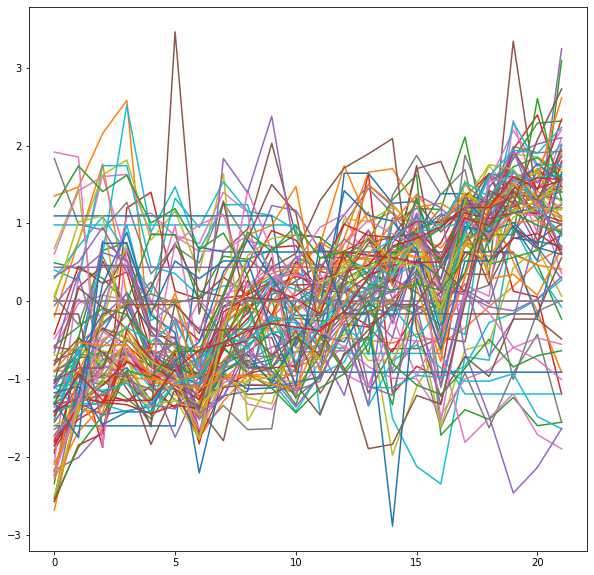

In [106]:
plt.figure(figsize=(10, 10))
plt.plot(tickers_scaled.T);

# Basic KMeans

  0%|          | 0/8 [00:00<?, ?it/s]

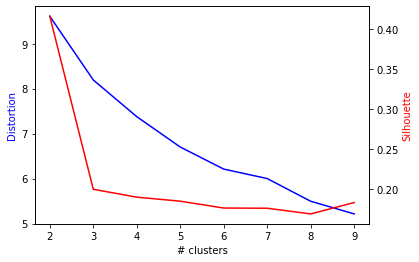

In [107]:
distortions = [] # Сумма кв расстояний от объектов до центра кластера, взвешенная по весам (при их наличии)
silhouette = []
K = range(2, 10)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="euclidean", n_jobs=6, max_iter=10, n_init=5)
    kmeanModel.fit(tickers_scaled)
    distortions.append(kmeanModel.inertia_)
    silhouette.append(silhouette_score(tickers_scaled, kmeanModel.labels_, metric="euclidean"))
    # silhouette_score считает насколько чисты кластеры
    
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(K, distortions, 'b-')
ax2.plot(K, silhouette, 'r-')

ax1.set_xlabel('# clusters')
ax1.set_ylabel('Distortion', color='b')
ax2.set_ylabel('Silhouette', color='r')

plt.show()

In [110]:
n_clusters = 4
ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", n_jobs=6, max_iter=10)
ts_kmeans.fit(tickers_scaled)

TimeSeriesKMeans(max_iter=10, n_clusters=4, n_jobs=6)

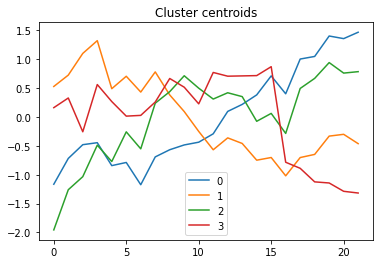

In [111]:
for cluster_number in range(n_clusters): # Построим усредненные ряды внутри каждого кластера
    plt.plot(ts_kmeans.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids") # Быки и медведи
plt.legend()
plt.show()

In [112]:
# посмотрим наличие корреляции между полученными кластерами и биржевыми секторами
full_ticker_df['cluster'] = ts_kmeans.predict(tickers_scaled)
pd.DataFrame(full_ticker_df.groupby('cluster')['sector'].value_counts())

sector
cluster sector                        
0       Technology                  12
        Healthcare                  10
        Consumer Cyclical            8
        Financial Services           8
        Industrials                  6
        Energy                       5
        Consumer Defensive           4
        Communication Services       3
        Real Estate                  2
        Basic Materials              1
        Utilities                    1
1       Communication Services       3
        Healthcare                   3
        Industrials                  2
        Consumer Cyclical            1
        Energy                       1
        Financial Services           1
        Technology                   1
2       Healthcare                   4
        Technology                   4
        Real Estate                  3
        Energy                       2
        Financial Services           2
        Basic Materials              1
        Consumer Cyclical            1
        Consumer Defensive           1
        Industrials                  1
3       Healthcare                   3
        Consumer Defensive           1
        Technology                   1

In [113]:
def plot_cluster_tickers(current_cluster):
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0]/4)),
        4,
        figsize=(15, 3*int(np.ceil(current_cluster.shape[0]/4)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)

    for index, (_, row) in enumerate(current_cluster.iterrows()):
        ax[index].plot(row.iloc[5:-1])
        ax[index].set_title(f"{row.shortName}\n{row.sector}")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

                          Cluster number: 0


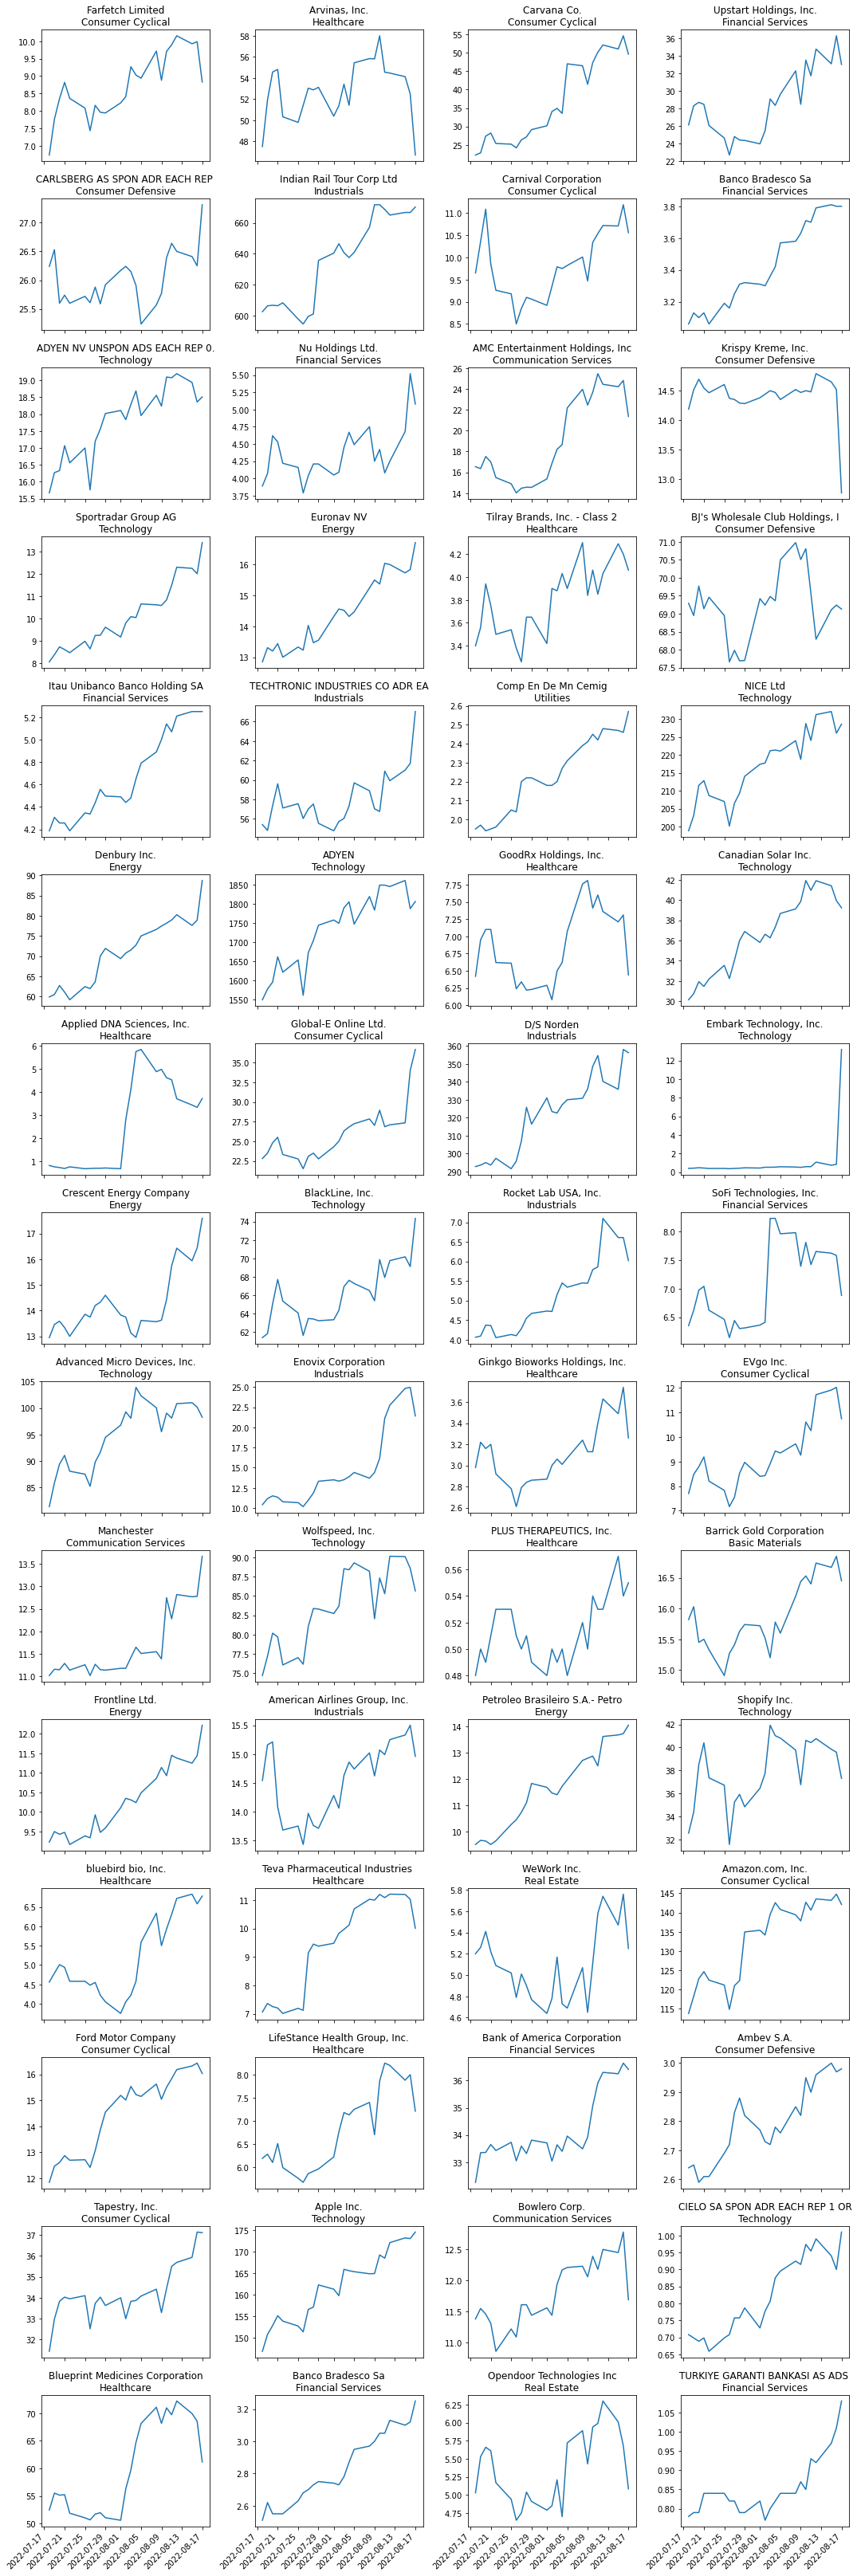

                          Cluster number: 1


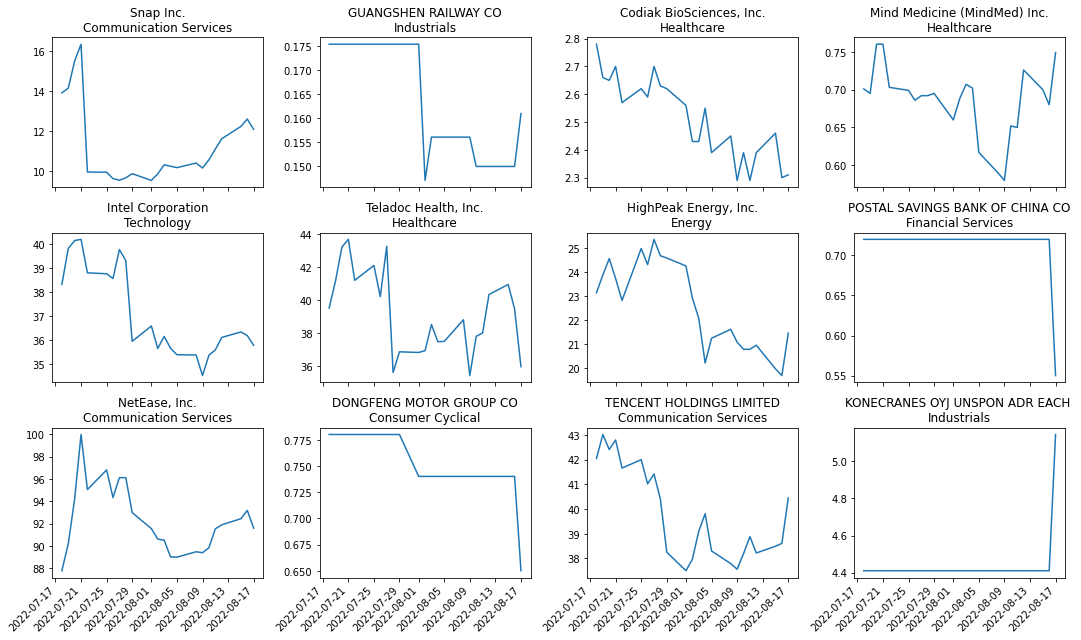

                          Cluster number: 2


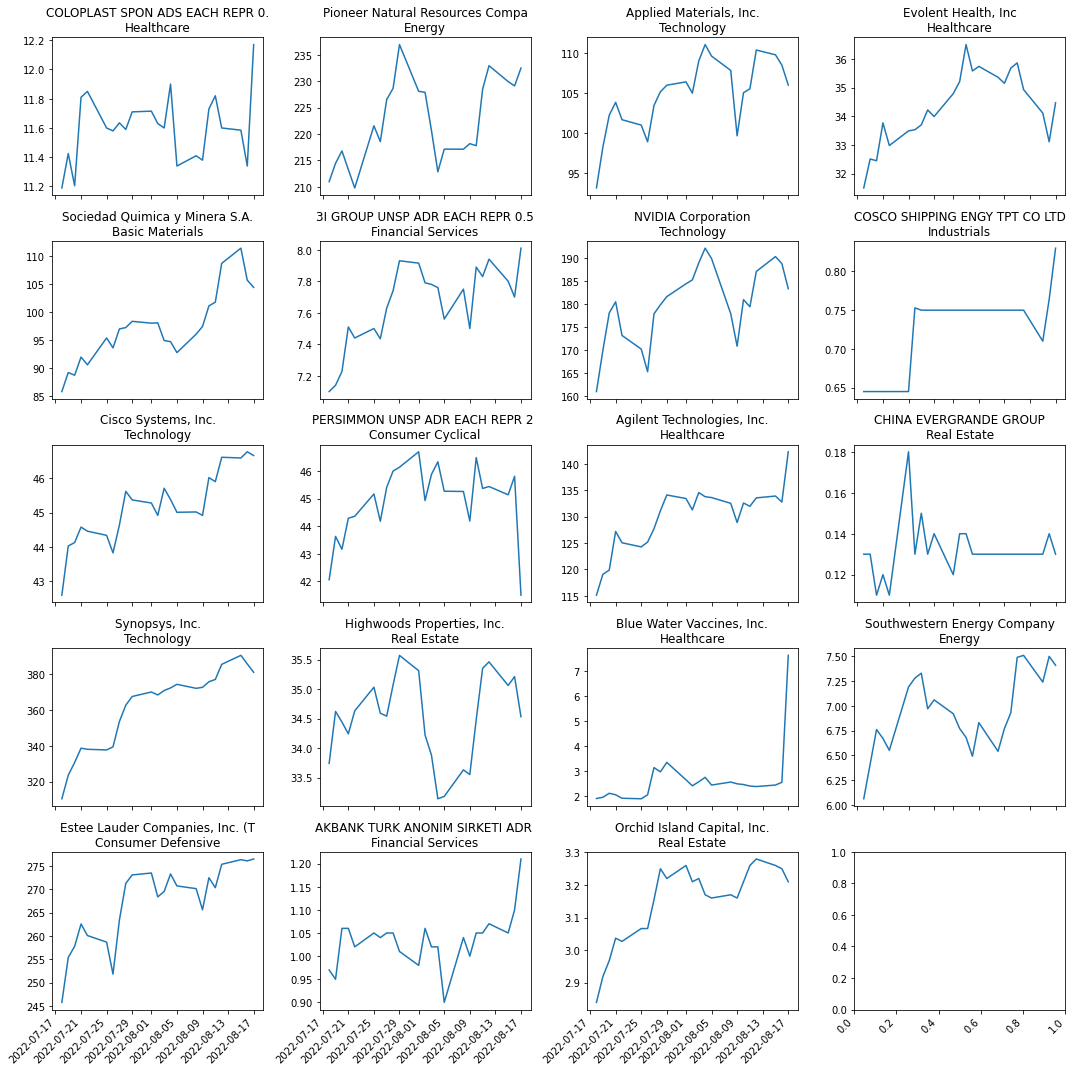

                          Cluster number: 3


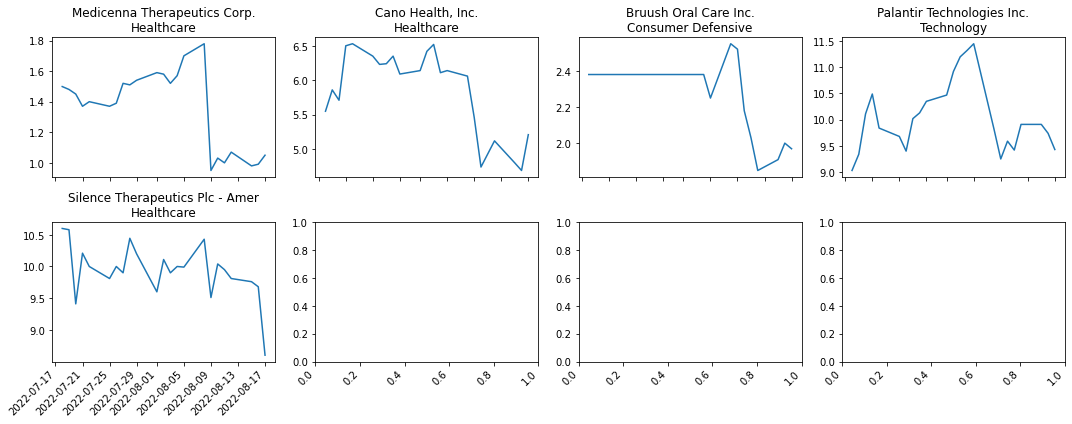

In [114]:
# TimeSeriesKMeans
for cluster in range(n_clusters):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(full_ticker_df[full_ticker_df.cluster==cluster])

# DTW

  0%|          | 0/8 [00:00<?, ?it/s]

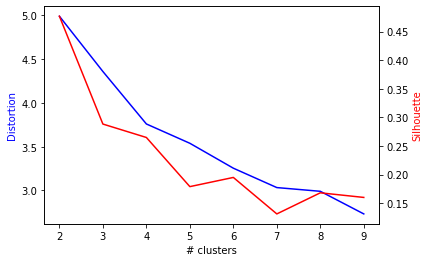

In [115]:
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
distortions = []
silhouette = []
K = range(2, 10)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="dtw", n_jobs=6, max_iter=10, n_init=5)
    kmeanModel.fit(tickers_scaled)
    distortions.append(kmeanModel.inertia_)
    silhouette.append(silhouette_score(tickers_scaled, kmeanModel.labels_, metric="dtw"))
    
    # silhouette_score считает насколько чисты класстеры
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
    # Для metric="dtw" берем реализацию из tslearn:
    # https://tslearn.readthedocs.io/en/stable/gen_modules/clustering/tslearn.clustering.silhouette_score.html

    
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(K, distortions, 'b-')
ax2.plot(K, silhouette, 'r-')

ax1.set_xlabel('# clusters')
ax1.set_ylabel('Distortion', color='b')
ax2.set_ylabel('Silhouette', color='r')

plt.show()

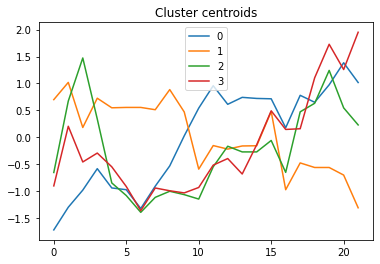

In [117]:
n_clusters = 4
ts_kmeans_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", n_jobs=6, max_iter=10,random_state=42)
ts_kmeans_dtw.fit(tickers_scaled)

for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans_dtw.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids")
plt.legend()
plt.show()

In [118]:
full_ticker_df['cluster'].value_counts()

0    60
2    19
1    12
3     5
Name: cluster, dtype: int64

In [119]:
full_ticker_df['cluster'] = ts_kmeans_dtw.predict(tickers_scaled)
pd.DataFrame(full_ticker_df.groupby('cluster')['sector'].value_counts())

sector
cluster sector                        
0       Technology                  14
        Healthcare                   7
        Consumer Cyclical            5
        Financial Services           5
        Energy                       3
        Industrials                  3
        Consumer Defensive           2
        Basic Materials              1
        Real Estate                  1
        Utilities                    1
1       Healthcare                   4
        Industrials                  2
        Communication Services       1
        Consumer Cyclical            1
        Consumer Defensive           1
        Energy                       1
        Financial Services           1
        Technology                   1
2       Healthcare                   4
        Consumer Defensive           3
        Real Estate                  3
        Communication Services       2
        Consumer Cyclical            1
        Energy                       1
        Technology                   1
3       Financial Services           5
        Healthcare                   5
        Industrials                  4
        Communication Services       3
        Consumer Cyclical            3
        Energy                       3
        Technology                   2
        Basic Materials              1
        Real Estate                  1

                          Cluster number: 0


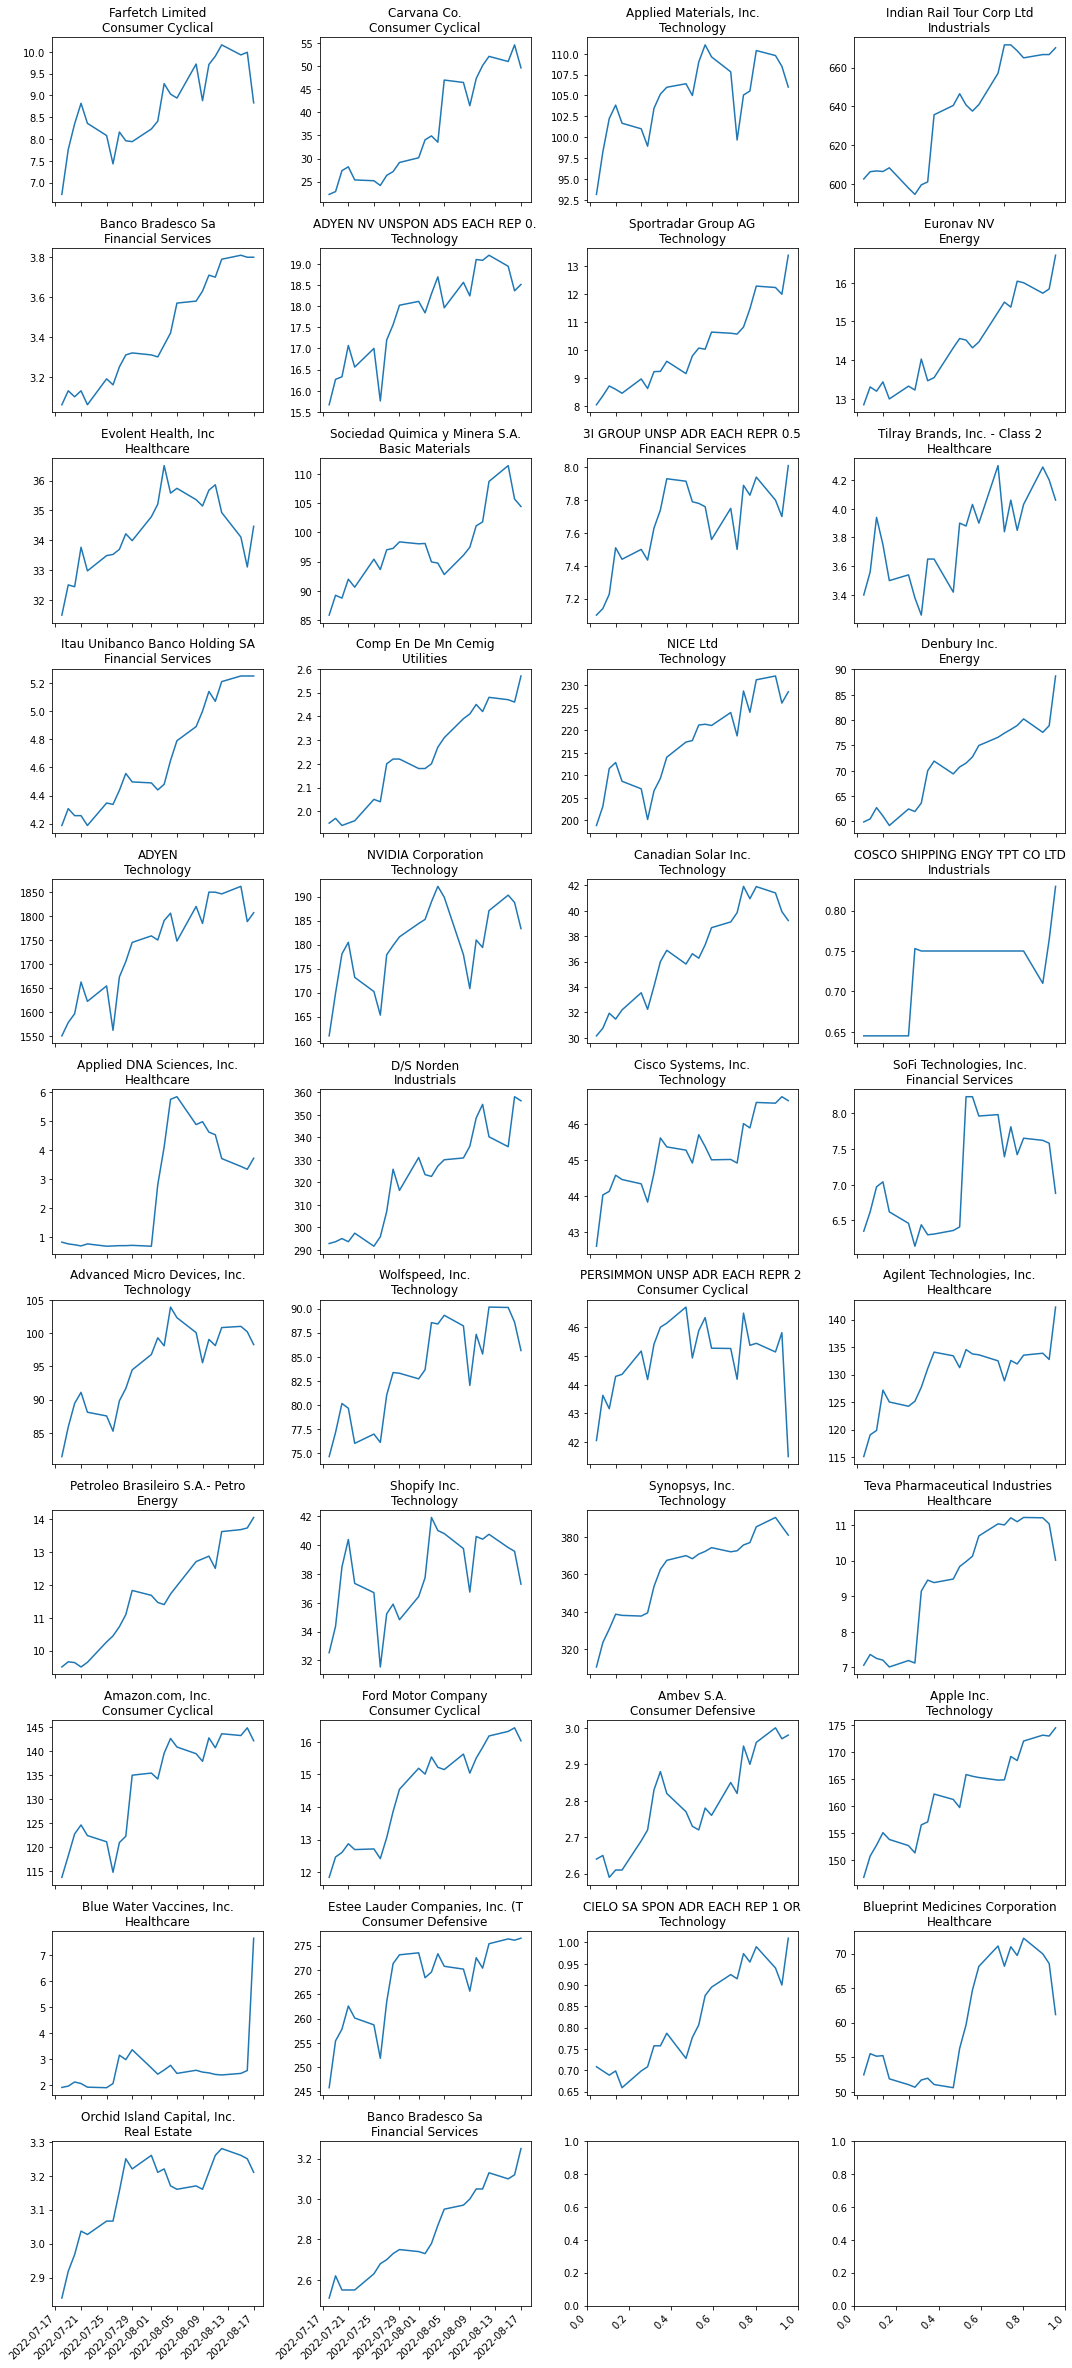

                          Cluster number: 1


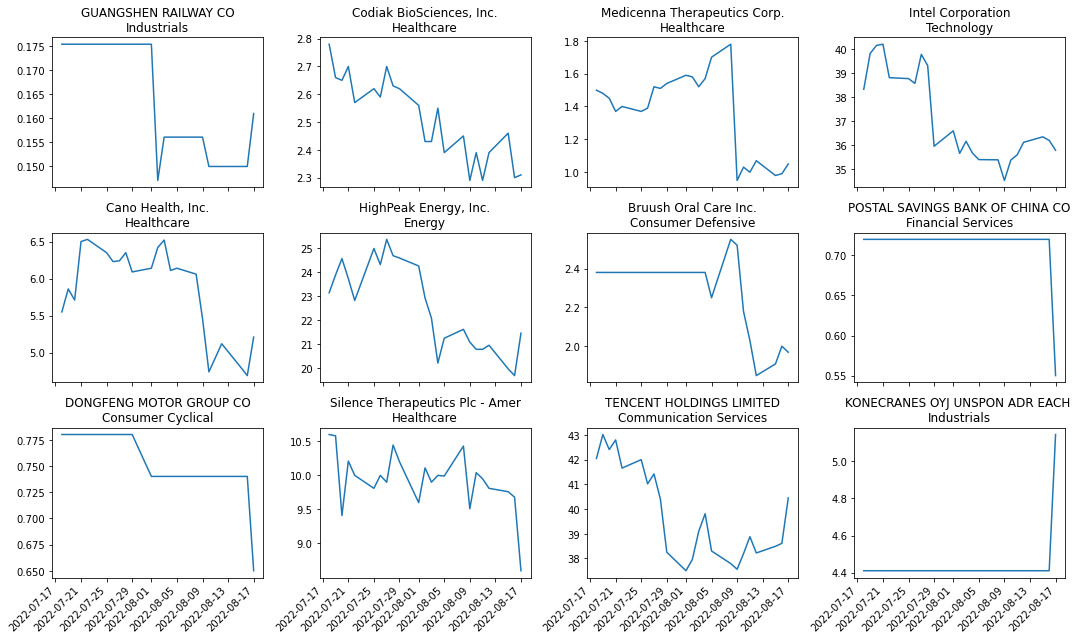

                          Cluster number: 2


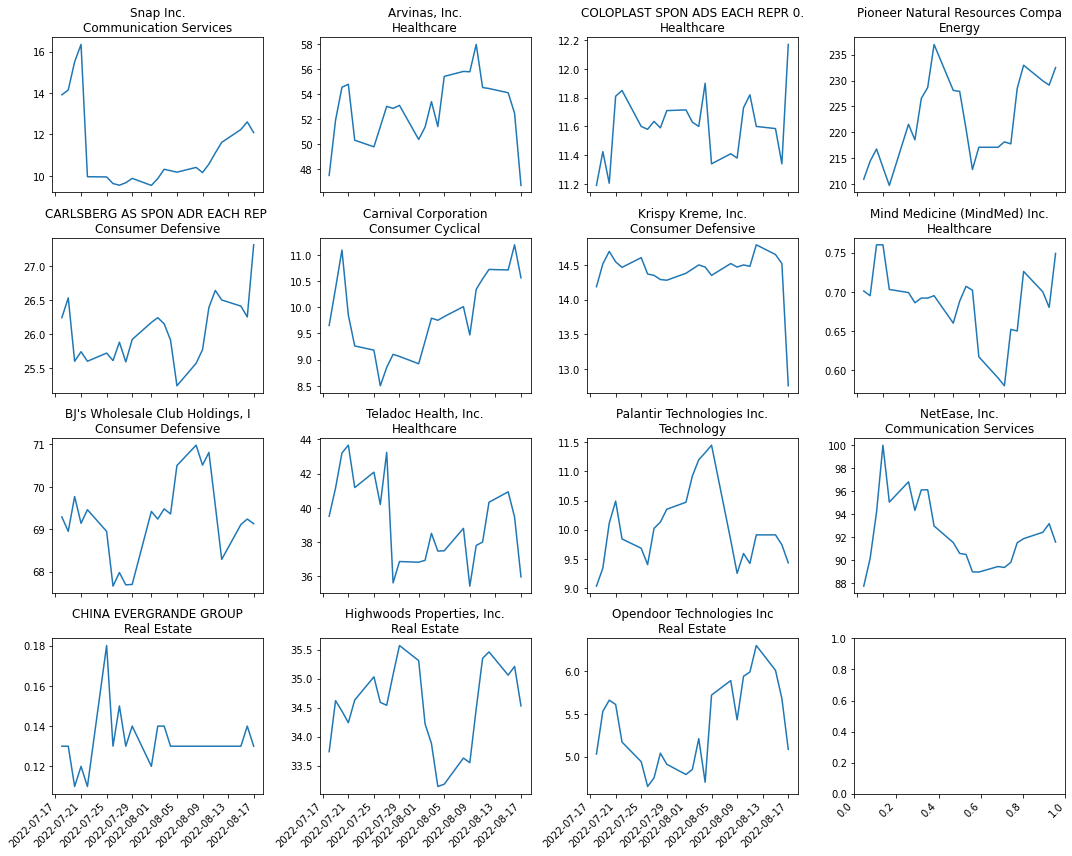

                          Cluster number: 3


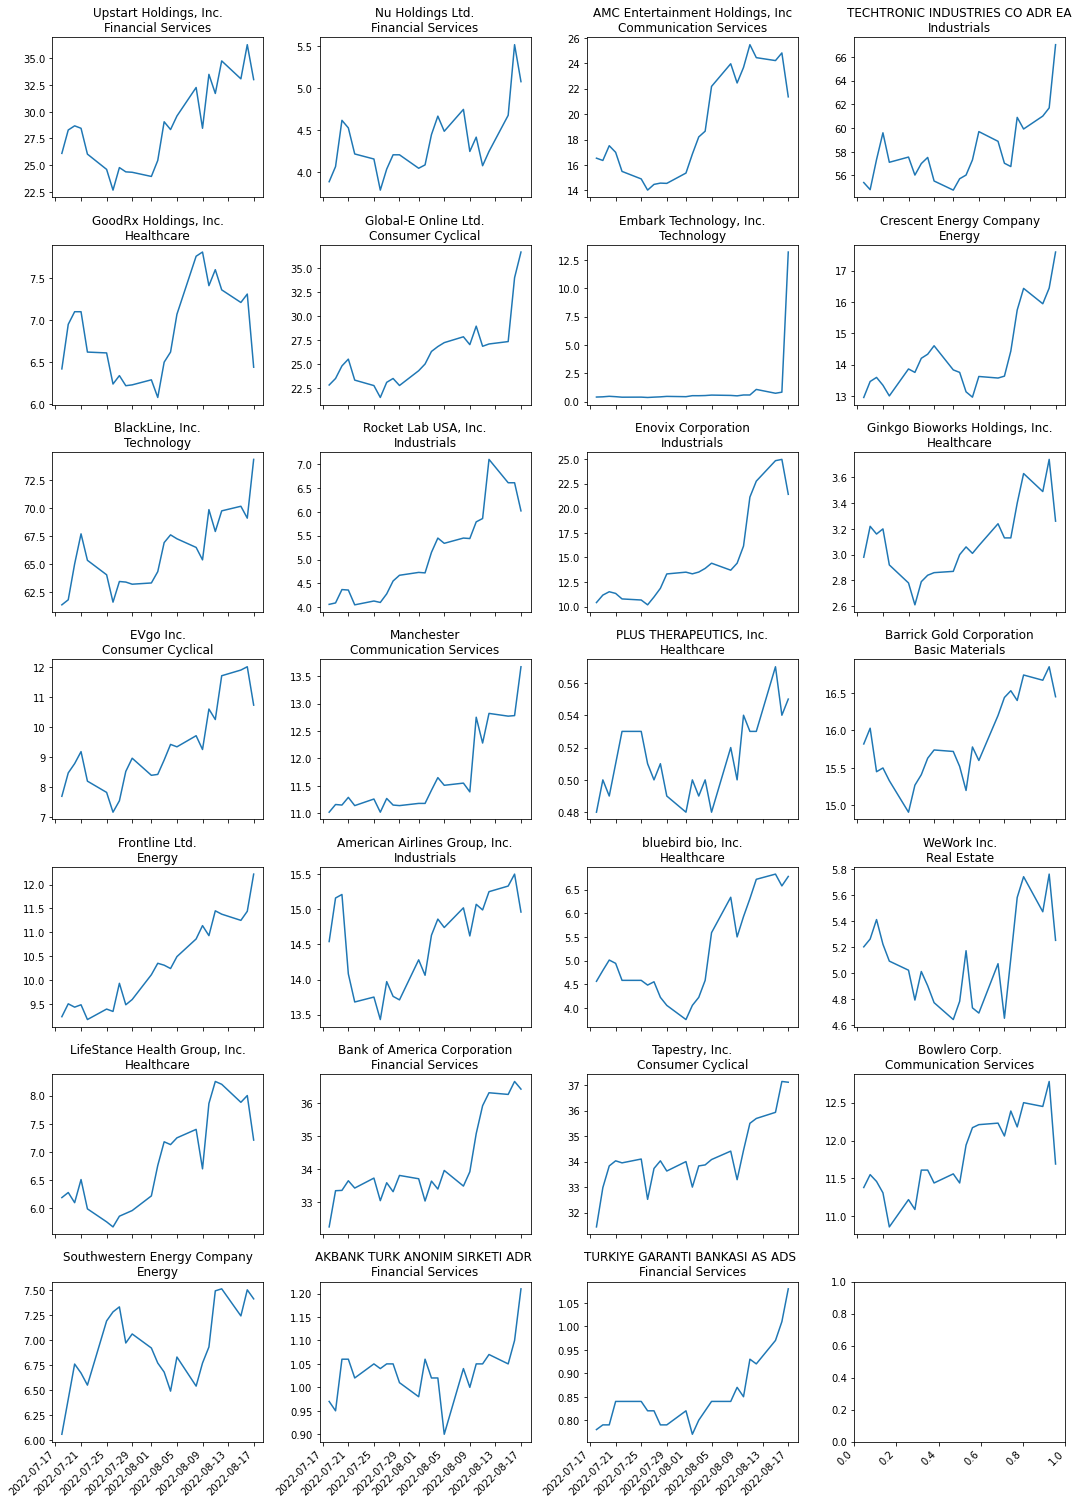

In [120]:
for cluster in range(n_clusters):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(full_ticker_df[full_ticker_df.cluster==cluster])